# Goals:


Build a machine learning model that predicts the **probability** that the first transaction of a new user is fraudulent. You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

- For each user, determine her country based on the numeric IP address.
- Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
- Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
- Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

In [1]:
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
PATH = Path('data')

from itertools import product

In [4]:
def ip2country(ip):
    ctry = df_country.loc[(df_country.lower_bound_ip_address <= ip) & (ip<=df_country.upper_bound_ip_address),'country'].values
    if len(ctry)==0: return 'NaN'
    if len(ctry)>1: raise ValueError('IP to Country is not 1 to 1')
    return ctry[0]

def date_breakdown(df,cols,drop=True):
    if not isinstance(cols,list):
        cols = [cols]
    for col in cols:
        df[col+'_day'] = df[col].dt.day
        df[col+'_month'] = df[col].dt.month
        df[col+'_dayofweek'] = df[col].dt.dayofweek
        df[col+'_hour'] = df[col].dt.hour
        df[col+'_minute']=df[col].dt.minute
        df[col+'_second']=df[col].dt.second
        if drop: df.drop(col,axis=1,inplace=True)

# Quick look

In [15]:
df = pd.read_csv(PATH/'Fraud_Data.csv')
df.columns = ['user_id'] +df.columns[1:].tolist()

In [16]:
df.tail()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0
151111,138208,2015-06-10 07:02:20,2015-07-21 02:03:53,20,ZINIADFCLHYPG,Direct,IE,M,38,4.103825e+09,0


In [17]:
df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [39]:
df['class'].value_counts()/len(df) * 100

0    90.635423
1     9.364577
Name: class, dtype: float64

In [41]:
df_country = pd.read_csv(PATH/'IpAddress_to_Country.csv')
df_country.tail()

,lower_bound_ip_address,upper_bound_ip_address,country
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore
138845,3.758096e+09,3758096383,Australia


# IP to country

In [71]:
# df['country']=df.ip_address.apply(ip2country)
# df.to_csv(PATH/'Fraud_Data_Country.csv',index=False)

In [17]:
df = pd.read_csv(PATH/'Fraud_Data_Country.csv',parse_dates=['signup_time','purchase_time'])
df=df.sort_values(['signup_time','purchase_time']).reset_index(drop=True)
df.drop('ip_address',axis=1,inplace=True)

In [18]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,country
0,286057,2015-01-01 00:00:42,2015-03-25 11:33:06,14,BBPACGBUVJUXF,Ads,Chrome,F,38,0,Korea Republic of
1,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of
2,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of
3,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of
4,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of


# Single feature EDA

In [22]:
df.signup_time.describe()

count                  151112
unique                 151112
top       2015-06-30 03:58:38
freq                        1
first     2015-01-01 00:00:42
last      2015-08-18 04:40:29
Name: signup_time, dtype: object

In [21]:
df.purchase_time.describe()

count                  151112
unique                 150679
top       2015-09-10 09:04:53
freq                        3
first     2015-01-01 00:00:44
last      2015-12-16 02:56:05
Name: purchase_time, dtype: object

In [24]:
df['day_old'] = (df.purchase_time-df.signup_time) / np.timedelta64(1,'D')

In [23]:
date_breakdown(df,['signup_time','purchase_time'],drop=False)

In [25]:
df.head().T

,0,1,2,3,4
user_id,286057,309557,124539,161246,356414
signup_time,2015-01-01 00:00:42,2015-01-01 00:00:43,2015-01-01 00:00:44,2015-01-01 00:00:45,2015-01-01 00:00:46
purchase_time,2015-03-25 11:33:06,2015-01-01 00:00:44,2015-01-01 00:00:45,2015-01-01 00:00:46,2015-01-01 00:00:47
purchase_value,14,14,14,14,14
device_id,BBPACGBUVJUXF,BBPACGBUVJUXF,BBPACGBUVJUXF,BBPACGBUVJUXF,BBPACGBUVJUXF
source,Ads,Ads,Ads,Ads,Ads
browser,Chrome,Chrome,Chrome,Chrome,Chrome
sex,F,F,F,F,F
age,38,38,38,38,38
class,0,1,1,1,1


<Figure size 720x360 with 0 Axes>

C:\Users\qtran\AppData\Local\Continuum\Miniconda3\envs\fastai-cpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


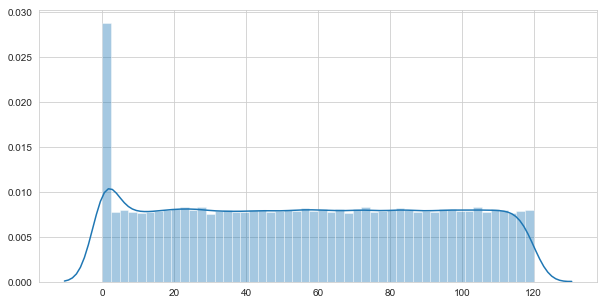

In [26]:
plt.figure(figsize=(10,5))
sns.distplot(df.day_old.values,kde=True)

C:\Users\qtran\AppData\Local\Continuum\Miniconda3\envs\fastai-cpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


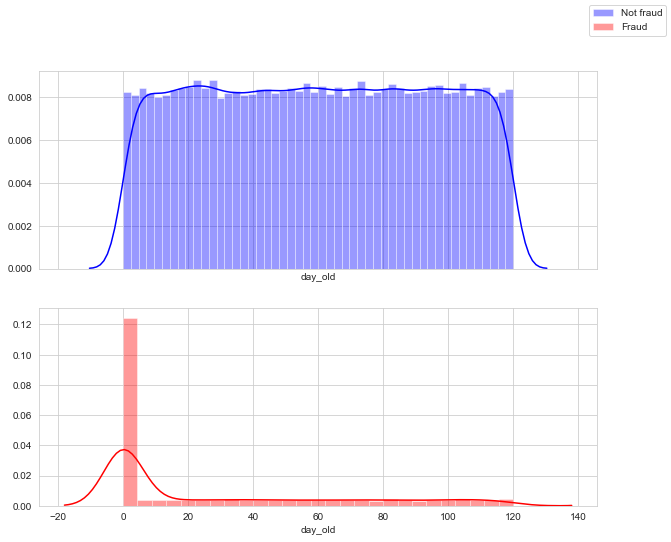

In [27]:
fig,axes = plt.subplots(2,1,figsize=(10,8),sharex=True)
_=sns.distplot(df[df['class']==0].day_old,kde=True,ax=axes[0],label='Not fraud',color='b')
_=sns.distplot(df[df['class']==1].day_old,kde=True,ax=axes[1],label='Fraud',color='r')
fig.legend()

We can see that if they make a purchase shortly after creating their account, the chance that it's a fraud transaction is high. Let's explore this more

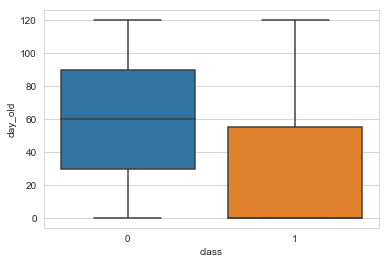

In [28]:
sns.boxplot(x='class',y='day_old',data=df,)

In [29]:
fraud_df = df[df['class']==1]

In [55]:
fraud_df.day_old.describe()

count    14151.000000
mean        28.053731
std         38.354037
min          0.000012
25%          0.000012
50%          0.000012
75%         55.445723
max        119.953090
Name: day_old, dtype: float64

In [69]:
len(fraud_df[fraud_df.day_old<=1]) / len(fraud_df)

0.5404565048406473

More than half of fradulent transaction involves account with less than 1-day old

In [103]:
temp = 1 # hour
df.loc[df.day_old<=(temp/24),'class'].value_counts() / len(df.loc[df.day_old<=(temp/24),'class'])

temp = 24 # hour
df.loc[df.day_old<=(temp/24),'class'].value_counts() / len(df.loc[df.day_old<=(temp/24),'class'])

1    0.995158
0    0.004842
Name: class, dtype: float64

1    0.873259
0    0.126741
Name: class, dtype: float64

More specifically, accounts with less than 1 hour old have 99% chance to be fraud. Accounts with less than 1 day old are 87% to be fraud

In [47]:
temp=df.copy()
temp['cumcnt_class']=temp.groupby('class').cumcount()

temp2=df.copy().sort_values('purchase_time')
temp2['cumcnt_class']=temp2.groupby('class').cumcount()

C:\Users\qtran\AppData\Local\Continuum\Miniconda3\envs\fastai-cpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


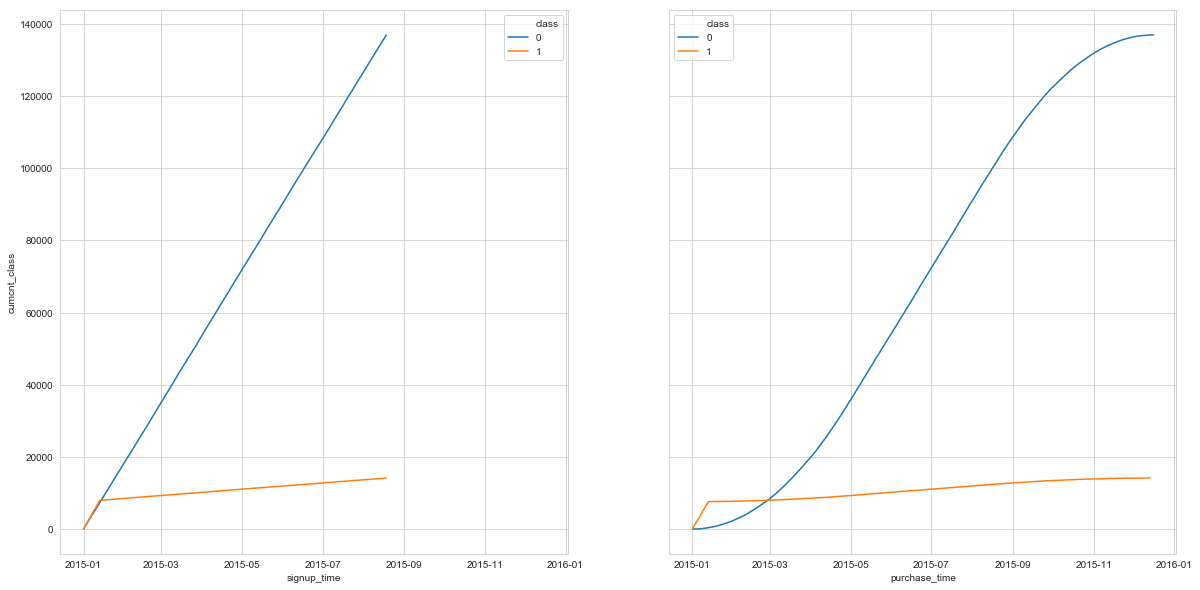

In [48]:
fig,axes=plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
_=sns.lineplot(x='signup_time',y='cumcnt_class',hue='class',data=temp,legend='full',ax=axes[0])
_=sns.lineplot(x='purchase_time',y='cumcnt_class',hue='class',data=temp2,legend='full',ax=axes[1])


These 2 are graphs of cummulative count of fraud vs nonfraud transaction, plotted against signup time (left graph) and purchase time (right graph). On both graph you can see the trend: within the first half of January 2015, there's a quick rise of fradulent people who sign up and purchase goods. This trend slows down after January. Since this is Holiday time, there could be a correlation between holiday time and fraud purchases  

We can ignore the weird sigmoid-shape growth of nonfradulent purchases from the right graph. Low growth on the left is because signup_time and purchase_time start at the same day on this dataset, thus we already discard accounts with earlier signup_time. Low growth on the right is because signup_time ends earlier than purchase_time (signup_time end around August, as seen on left graph) so we discard accounts created after August

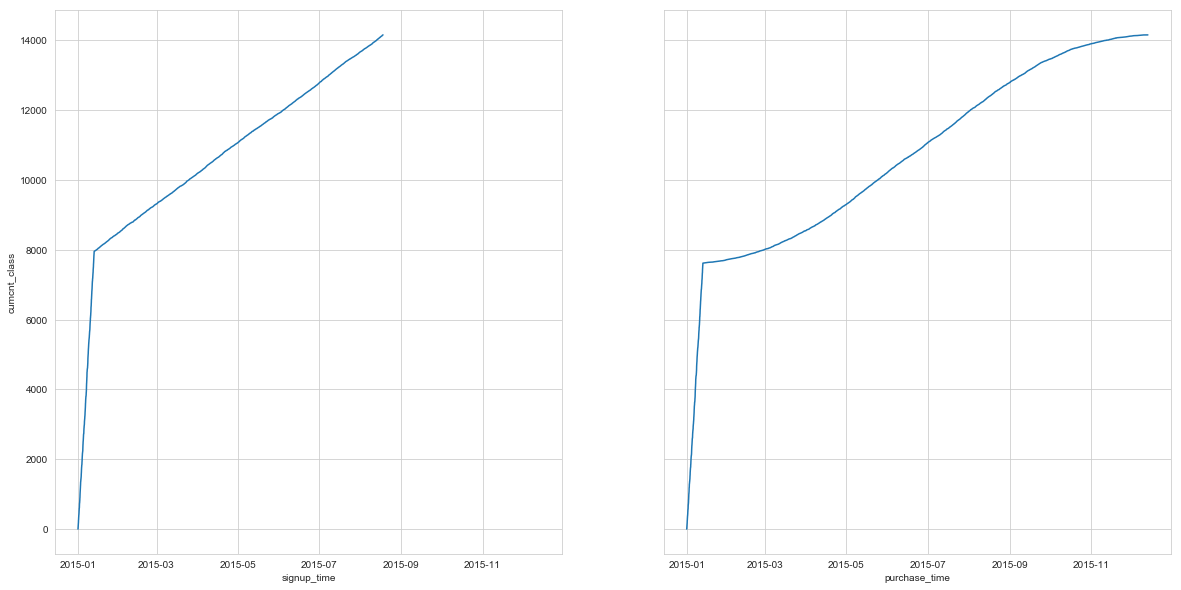

In [56]:
fraud_df = df[df['class']==1]
temp=fraud_df.copy()
temp['cumcnt_class']=temp.groupby('class').cumcount()

temp2=fraud_df.copy().sort_values('purchase_time')
temp2['cumcnt_class']=temp2.groupby('class').cumcount()

fig,axes=plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
_=sns.lineplot(x='signup_time',y='cumcnt_class',data=temp,ax=axes[0])
_=sns.lineplot(x='purchase_time',y='cumcnt_class',data=temp2,ax=axes[1])


There's a whooping ~8000 fraudulent purchases on the first 2 weeks of January